# Edge Reflections

In [3]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from hypertiling import HyperbolicTiling
from hypertiling.graphics.plot import plot_geodesic, convert_edges_to_arcs
from hypertiling.geodesics import geodesic_arc

In this notebook we demonstrate how reflection across polygon edges can be realized with hypertiling

## Poincare disk representation

We demonstrate how any polygon in a tiling can be reflect across one of its edges. This is exactly what is heavily done in the GR kernel family in hypertiling. The steps are
- translation
- rotation
- conjugation
- inverse rotation
- inverse translation

In [4]:
p, q = 5, 4
T = HyperbolicTiling(p, q, 2)

In [5]:
k = 1 # select polygon
i = 3 # select edge to be reflected at

steps, titles = [], []

orig = T.get_polygon(k)
vrts = T.get_vertices(k)

titles.append("step 1 \n original polygon")
newpoly = copy.deepcopy(orig)
steps.append(copy.deepcopy(newpoly))

# translate, rotate, conjugate, rotate back, translate back

titles.append("step 2 \n translate vertex to origin")
newpoly.moeb_origin(vrts[i])
steps.append(copy.deepcopy(newpoly))

titles.append("step 3 \n rotate edge on x-axis")
angle = np.angle(newpoly.get_polygon()[(i + 1) % p])
newpoly.moeb_rotate(angle)
steps.append(copy.deepcopy(newpoly))

titles.append("step 4 \n conjugate (mirror on x-axis)")
newpoly._vertices = np.conjugate(newpoly.get_polygon())
steps.append(copy.deepcopy(newpoly))

titles.append("step 5 \n inverse rotation")
newpoly.moeb_rotate(-angle)
steps.append(copy.deepcopy(newpoly))

titles.append("step 6 \n inverse translation")
newpoly.moeb_origin(-vrts[i])
steps.append(copy.deepcopy(newpoly))

Visualize sequence of steps

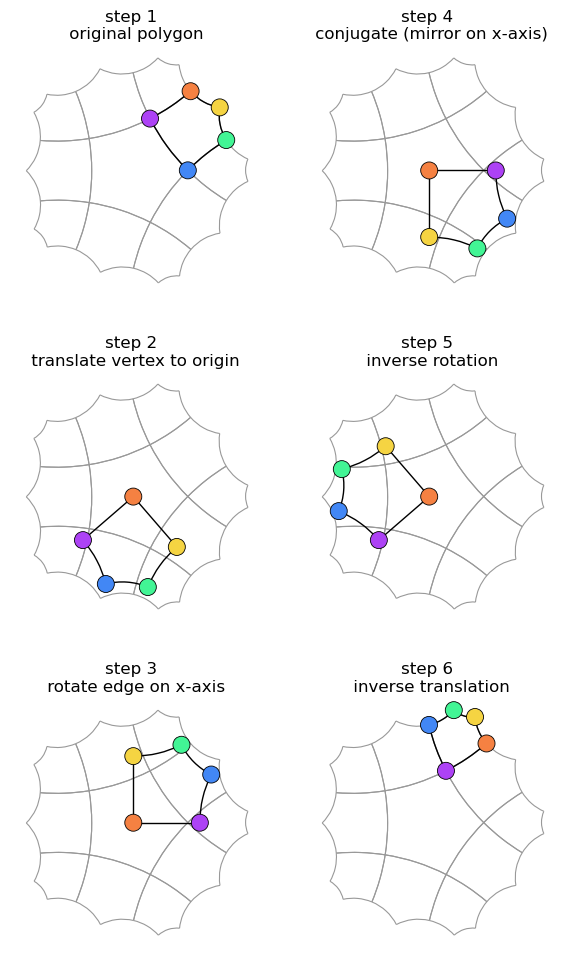

In [6]:
# colors help to identify points: blue, green, yellow, orange, purple
C = np.array([[66, 135, 245], [66, 245, 149], [245, 212, 66], [245, 129, 66], [173, 66, 245]])

midx = [(0,0), (1,0), (2,0), (0,1), (1,1), (2,1)] # multi index helper

fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, dpi=100, figsize=(7, 12))
for i, ps in enumerate(steps):
    edges, _ = convert_edges_to_arcs(T, ec="0.6", lw=0.8)
    for edge in edges:
        axes[midx[i]].add_artist(edge)
    k = list(ps.get_vertices())
    axes[midx[i]].scatter(np.array(k).real, np.array(k).imag, ec="k", lw=0.6, s=150, c=C/255.0, alpha=1, zorder=3)
    k = k + [k[0]]
    for j in range(len(k)-1):
        arc = geodesic_arc(k[j], k[j+1], ec="k", lw=1.0)
        axes[midx[i]].add_artist(arc)
    axes[midx[i]].axis("off")
    axes[midx[i]].set_aspect('equal')
    axes[midx[i]].set_xlim(-0.9, 0.9); axes[midx[i]].set_ylim(-0.9, 0.9)
    axes[midx[i]].set_title(titles[i])

## Weierstraß (hyperboloid) representation

Analogous transformations can be performed in the hyperboloid representation. This is used in the Dunham algorithm, also implemented in hypertiling.

In [7]:
from hypertiling.representations import w2p_xyt, p2w_xyt
from scipy.stats import circmean

In [8]:
p, q = 5, 4 
T = HyperbolicTiling(p, q, 2)

We gonna need this particular reflection matrix

In [9]:
b = np.arccosh(np.cos(np.pi / q) / np.sin(np.pi / p))

ReflectPgonEdge = np.array([[-np.cosh(2 * b), 0, np.sinh(2 * b)],
                                 [0, 1, 0],
                                 [-np.sinh(2 * b), 0, np.cosh(2 * b)]])

Define a number of helpers

In [10]:
def p2w(zs):
    # Poincare to Weierstrass
    return [p2w_xyt(x) for x in zs]


def w2p(xyts):
    # Weierstrass to Poincare
    return [w2p_xyt(z) for z in xyts]


def trafoW(xyts, trafo):
    # Apply Weierstrass transformation matrix
    return [trafo@k for k in xyts]


def rotationW(phi):
    # return Weierstrass rotation matrix
    return np.array([[np.cos(phi), -np.sin(phi), 0], [np.sin(phi), np.cos(phi), 0], [0, 0, 1]])

Extract fundamental polygon and convert to Weierstrass representation

In [11]:
fund = p2w(T.get_vertices(0))

Build reflection transformation

In [12]:
# select edge
i = 4
j = int((i+1) % p)

# calculate angle of mean point of this edge
phi1 = np.angle(complex(fund[i][0], fund[i][1]))
phi2 = np.angle(complex(fund[j][0], fund[j][1]))
phi = circmean([phi1,phi2])

In [13]:
# perform a series of transformation
# goal: reflect fundamental poly across selected edge
titles = []

titles.append("step 1 \n fundamental polygon")
step1 = fund

titles.append("step 2 \n rotate such that edge is parallel to y-axis")
step2 = trafoW(step1, rotationW(phi))

titles.append("step 3 \n reflect on this edge")
step3 = trafoW(step2, ReflectPgonEdge)

titles.append("step 4 \n rotate back")
step4 = trafoW(step3, rotationW(-phi))

Visualize sequence of steps

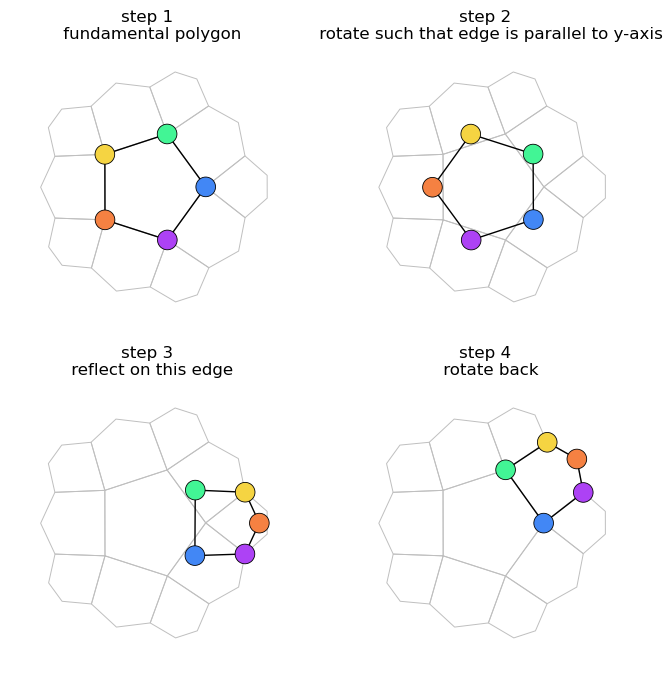

In [14]:
# select which steps are to be plotted
steps = [step1, step2, step3, step4]

# colors help to identify points: blue, green, yellow, orange, purple
C = np.array([[66, 135, 245], [66, 245, 149], [245, 212, 66], [245, 129, 66], [173, 66, 245]])

midx = [(0,0), (0,1), (1,0), (1,1)] # multi index helper

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, dpi=100, figsize=(8, 8))
for i, ps in enumerate(steps):
    k = w2p(ps)  # transform back to Poincare
    for j in range(len(T)):
        vs = T.get_vertices(j)
        vs = np.append(vs, vs[0])
        axes[midx[i]].plot(vs.real, vs.imag, c="0.75", lw=0.7, zorder=1)
    axes[midx[i]].scatter(np.array(k).real, np.array(k).imag, ec="k", lw=0.6, s=200, c=C/255.0, alpha=1, zorder=3)
    axes[midx[i]].plot(np.array(k+[k[0]]).real, np.array(k+[k[0]]).imag, c="k", lw=1, zorder=2)
    axes[midx[i]].axis("off")
    axes[midx[i]].set_aspect('equal')
    axes[midx[i]].set_xlim(-1, 1); axes[midx[i]].set_ylim(-1, 1)
    axes[midx[i]].set_title(titles[i])